In [1]:
import networkx as nx
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import stanza
import math
import random
from itertools import combinations, product
%matplotlib inline

In [2]:
# Collection of functions that help me process the raw text into a graph using the parsing result.
def spanner(sentence, return_raw=False):
    """ 
    recombine tokens into entity based on 'ner' indicator 
    input: a raw sentence
    output: a stanza Doc object re-tokenized based on combination of terms that are biomedically relevant
    """
    # Using stanford NLP developed Stanza to process the sentence
    # bionlp13cg is a corpus used for NER task on biomedical related text
    pretokenized_nlp = stanza.Pipeline('en', package='craft', processors={'ner': 'bionlp13cg'}, tokenize_pretokenized=True, verbose=False)
    nlp = stanza.Pipeline('en', package='craft', processors={'ner':'bionlp13cg'}, verbose=False)
    
    doc = nlp(sentence)
    cur_ent = []
    tokenized_sent = []
    
    # Recombine tokens based on NER result instead of raw tokens
    for sent in doc.sentences:
        for token in sent.tokens:
            if (token.ner == "O" or token.ner.startswith('S-')):
                tokenized_sent.append(token.text)
            elif token.ner.startswith('B-') or token.ner.startswith('I-'):
                cur_ent.append(token.text)
            elif token.ner.startswith('E-'):
                cur_ent.append(token.text)
                new_span = ' '.join(cur_ent)
                if ' - ' in new_span:
                    new_span = new_span.replace(' - ','-')
                tokenized_sent.append(new_span)
                cur_ent = []
            else:
                pass
    # control the return; whether to return a stanza doc object or raw text
    if return_raw:
        return tokenized_sent, len(tokenized_sent)
    else:
        retokenized_doc = pretokenized_nlp([tokenized_sent])
        return retokenized_doc, len(tokenized_sent)
    
def consolidatedPassSpanner(doc):
    """
    A custom built function to combine certain tokens together
    Currently, there are two basic recombination rules
    1. recombine two consecutive tokens that are both 'NOUN'
    2. recombine two consecutive tokens that are part of the 'VERB' in passive voice
    Input: a stanza doc
    Output: a retokenized stanza doc
    '"""
    retokenized_txt = []
    for sent in doc.sentences:
        count = 0
        while count < len(sent.words):
            if count+1<len(sent.words) and (sent.words[count].upos == 'NOUN' and sent.words[count].xpos=='NN') and (sent.words[count+1].upos=='NOUN' and sent.words[count+1].xpos=='NN'):
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            elif count+1<len(sent.words) and sent.words[count].upos == 'AUX' and sent.words[count+1].upos=='VERB':
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            else:
                retokenized_txt.append(sent.words[count].text)
                count +=1
    return retokenized_txt

def dynamicReSpanner(doc, length):
    """
    A custom built function to recombine tokens using function consolidatedPassSpanner.
    This function will dynamically recombine the tokens based on its last POS tag until there is no
    further feasible recombination.
    """
    pretokenized_biomedicalnlp = stanza.Pipeline(lang='en', package='craft', processors={'ner': 'bionlp13cg'}, tokenize_pretokenized=True, verbose=False) 
    prev_size = length
    while True:
        pretokenized_sent = consolidatedPassSpanner(doc)
        doc = pretokenized_biomedicalnlp([pretokenized_sent])
        next_size = len([word.text for sent in doc.sentences for word in sent.words])
        print ('Prev size: %i Vs. Next size %i' %(prev_size, next_size))
        if next_size == prev_size:
            break
        else:
            prev_size=next_size
    return doc

def spannerWrapper(sent):
    """
    A function to combine the functions "dynamicReSpanner" and "spanner" to allow more complex operation
    on the sentence
    """
    doc_1, length = spanner(sent)
    doc_2 = dynamicReSpanner(doc_1, length)
    return doc_2

def printDoc(doc):
    print(*[f'id: {word.id}\tword: {word.text.ljust(25, " ")}\tupos: {word.upos.ljust(6, " ")}\txpos: {word.xpos.ljust(6, " ")}\thead: {sent.words[word.head-1].text.ljust(15, " ") if word.head > 0 else "root"}' for sent in doc.sentences for word in sent.words], sep='\n')


In [3]:
# Collection of functions that allows me to construct a graph representing the sentence structure
def createTokenDiGraphwithContraction(doc):
    g = nx.DiGraph()
    # dependency chain that reflects the connection between words based on dependency parsing output
    # https://stanfordnlp.github.io/stanza/depparse.html
    # I am using the syntactic head of each word in a sentence and the dependency relation 
    # between the two words that are accessible through Word’s head and deprel attributes
    # to construct the graph.
    # In addition, I add a linear directed link between adjacent tokens to represent the sequence of tokens.
    # Note: all node and edge weights are initiated with a value of 1.
    
    # Connection between token and its head
    for sent in doc.sentences: 
        for word in sent.words:
            tail = word.text
            tail_dep = word.deprel
            tail_nature = word.upos
            head = sent.words[word.head-1].text
            head_dep = sent.words[word.head-1].deprel
            head_nature = sent.words[word.head-1].upos
            g.add_node(head, deprel=head_dep, pos=head_nature, weight=1)
            g.add_node(tail, deprel=tail_dep, pos=tail_nature, weight=1)
            g.add_edge(head, tail, weight=1)
    # linear chain that reflects the order of words in the sentence
    for sent in doc.sentences: 
        for i in range(len(sent.words)-1):
            g.add_edge(sent.words[i].text, sent.words[i+1].text, weight=1)
    # Remove the end '#' if present and punctuation        
    h = contract(g)
    h = removePunct(h)
    return h

def createTokenDiGraphwithContractionwithJump(doc):
    g = nx.DiGraph()
    # dependency chain that reflects the connection between words based on dependency parsing output
    # https://stanfordnlp.github.io/stanza/depparse.html
    # I am using the syntactic head of each word in a sentence and the dependency relation 
    # between the two words that are accessible through Word’s head and deprel attributes
    # to construct the graph.
    # In addition, I add a linear directed link between adjacent tokens to represent the sequence of tokens.
    # Note: all node and edge weights are initiated with a value of 1.
    
    # Connection between token and its head
    for sent in doc.sentences: 
        for word in sent.words:
            tail = word.text
            tail_id = word.id
            tail_dep = word.deprel
            tail_nature = word.upos
            head = sent.words[word.head-1].text
            head_id = sent.words[word.head-1].id
            head_dep = sent.words[word.head-1].deprel
            head_nature = sent.words[word.head-1].upos
            g.add_node(head, deprel=head_dep, pos=head_nature, weight=1)
            g.add_node(tail, deprel=tail_dep, pos=tail_nature, weight=1)
            # New approach that allows jump from the front of a sentence to rear end without going
            # through the linear chain. It is different from the previous approach that enables 
            # jump back to the head of a sentence from rear.
            if head_id>tail_id:
                g.add_edge(head, tail, weight=1)
            else:
                g.add_edge(tail, head, weight=1)
    # linear chain that reflects the order of words in the sentence
    for sent in doc.sentences: 
        for i in range(len(sent.words)-1):
            g.add_edge(sent.words[i].text, sent.words[i+1].text, weight=1)
    # Remove the end '#' if present and punctuation        
    h = contract(g)
    h = removePunct(h)
    return h

def contract(g):
    # function to remove an '#' that indicates the end of a sentence
    if '#' in g.nodes:
        for n in g.neighbors('#'):
            if g.nodes[n]['pos']=='VERB' or g.nodes[n]['pos']=='PART' or g.nodes[n]['pos']=='AUX' or g.nodes[n]['pos']=='NOUN' or g.nodes[n]['pos']=='PROPN':
                h = nx.contracted_nodes(g, n, '#')
                return h
            else:
                return g
    else:
        return g

def removePunct(g):
    # function to remove any punctuation that is not relevant to the explanation
    nodes_lst = list(g.nodes)
    for node in nodes_lst:
        if g.nodes[node]['pos'] =='PUNCT':
            g.remove_node(node)
    return g

def plot_circular_network(graph):
    # A simple function to plot the graph constructed by function "createTokenDiGraphwithContraction"
    plt.figure(figsize=(20,20))
    pos = nx.circular_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_color='r')
    nx.draw_networkx_labels(graph, pos, font_size = 14)
    nx.draw_networkx_edges(graph, pos, edge_color='b')
    plt.show()

In [59]:
def get_Weighted_Neighbours(G, node):
    """ 
    Generate a list of neighbours with their corresponding probabilities starting of a given node
    """
    node_weights = nx.get_node_attributes(G, "weight")
    
    # Prepare neighbour list and obtain weight attribute for nodes and edges
    edge_wgts = nx.get_edge_attributes(G, "weight")
    node_neighbours = [adj_node for adj_node, datadict in G[node].items()]
    self_node_wgt = np.array(len(node_neighbours))*node_weights[node] # populate a weight vector same shape of its neighbours
    neighbour_wgts = [datadict['weight'] for adj_node, datadict in G[node].items()]
    neighbour_pair_wgts = list()
    for neigbhour in node_neighbours:
        neighbour_pair_wgts.append(edge_wgts[(node, neigbhour)])
    
    # Calculate the transition probability from start node to respective neighbour
    elementwise_wgts = np.multiply(self_node_wgt, np.array(neighbour_wgts) , np.array(neighbour_pair_wgts)) #
    total_weight = sum(elementwise_wgts)
    neighbour_prob = [weight/total_weight for weight in elementwise_wgts]
    
    return node_neighbours, neighbour_prob

def get_nextNode(G, start_node):
    """ 
    obtain next outgoing node of a given start_node
    """
    neighbour_list, neighbour_prob = get_Weighted_Neighbours(G, start_node)
    if len(neighbour_list)!=0:
        next_node = random.choices(neighbour_list, neighbour_prob)
    else:
        next_node = [start_node]
    return next_node

def get_random_walk(graph, start_node):  
    """ 
    Given a DiGraph and a node, 
    return a random walk starting from the node 
    """
    local_path = [start_node]
    node = start_node
    n_steps = len(graph.nodes)*2
    for i in range(n_steps):
        next_node = get_nextNode(graph, node)
        local_path.append(next_node[0])
        node = next_node[0]
    return local_path

def updateNodeWt(G):
    """
    Input: a networkx DiGraph
    Output: a networkx DiGraph with updated node weight
    """
    pos = nx.get_node_attributes(G, 'pos')
    for node, pos in pos.items():
        if pos=='VERB' or node=='not':
            G.nodes[node]['weight']=math.exp(2) # ~ 7.38905609893
        elif pos=='NOUN':
            G.nodes[node]['weight']=math.exp(1) # ~ 2.71828182846
        else:
            G.nodes[node]['weight']=math.exp(0) # = 1
    return G

def updateEntWt(G, doc):
    """
    Input: a networkx DiGraph
    Output: a networkx DiGraph with updated entity weight, replace the assignment under UpdateNodeWt() function
    """    
    ents = [ent.text for sent in doc.sentences for ent in sent.ents if ent.type=='GENE_OR_GENE_PRODUCT']
    print (ents)
    for node in G.nodes():
        if node in ents:
            G.nodes[node]['weight']=math.exp(3) # ~ 20.0855369232
    return G

def updateEdgeWt(G):
    """
    Input: a networkx DiGraph
    Output: a networkx DiGraph with updated edge weight
    """    
    edges = nx.get_edge_attributes(G, 'weight')
    nodes = nx.get_node_attributes(G, 'weight')
    for edge, weight in edges.items():
        G.edges[edge]['weight'] = math.sqrt(nodes[edge[0]]*nodes[edge[1]])
    return G

def generateRandomWalkwithTarget(graph, source, target, max_len = 50):
    """ 
    Given a DiGraph and a node, 
    return a random walk starting from the source and end either at target node 
    or walks exceed the length of maximum length 
    """
    local_path = [source]
    node = source
    for i in range(max_len):
        next_node = get_nextNode(graph, node)
        #print (next_node)
        local_path.append(next_node[0])
        if next_node[0]!=target and len(local_path)<=max_len:
            #print(next_node!=target and len(local_path)<=max_len)
            node = next_node[0]
            #print(node)
        else:
            break
    return local_path

def generateSimpleWeightedPaths(graph, cycle=200):
    """
    Function to collect walks generated by generateRandomWalkwithTarget()
    """
    all_walks = []
    for t in graph.nodes:
        for s in graph.nodes:
            for i in range(cycle):
                ps = generateRandomWalkwithTarget(graph, source=s, target=t)
                all_walks.append(ps)
    return all_walks

In [5]:
def startNode(graph):
    s = []
    for node in graph.nodes:
        if graph.in_degree(node)==0:
            s.append(node)
    return s

def terminalNode(graph):
    t = []
    for node in graph.nodes:
        if graph.out_degree(node)==0:
            t.append(node)
    return t

def inBetweenNode(graph):
    i = []
    for node in graph.nodes:
        if graph.in_degree(node)>0 and graph.out_degree(node)>0:
            i.append(node)
    return i

In [6]:
# Collection of functions to calculate Bayes probability
def BayesProb(target, conditional, ps):
    """
    Calculate conditional probability
    Input:
    Target = numerator of the probility function
    conditional_on = denominator of the probability function
    p = a collection of random walks
    Output:
    a conditional probability
    Note: it doesn't take into consideration of the adjancency of two nodes in counting 
    the number of occurence
    """
    numerator = 0
    denominator = 0
    all_elements = target + conditional
    print (all_elements, conditional)
    for p in ps:
        if len(set(all_elements).intersection(set(p)))==len(set(all_elements)):
            numerator +=1
        if len(set(conditional).intersection(set(p)))==len(set(conditional)):
            denominator +=1
    print ('Numerator: %i; Denominator: %i' %(numerator, denominator))
    if denominator==0:
        Pr = 0
        print (('Pr(' + str(target) +'|' + str(conditional)+')' + ': %.6f') %(Pr))
        return Pr
    else:
        Pr = numerator/denominator
        print (('Pr(' + str(target) +'|' + str(conditional)+')' + ': %.6f') %(Pr))
        return Pr
    

In [7]:
# A sample sentence from biomedical domain is used to demonstrate the approach
sent = 'In contrast, the product of the human CDKN2A beta transcript, p14ARF, activates a p53 response manifest in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2/M.'
print (sent)

In contrast, the product of the human CDKN2A beta transcript, p14ARF, activates a p53 response manifest in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2/M.


In [8]:
doc = spannerWrapper(sent)

Prev size: 35 Vs. Next size 32
Prev size: 32 Vs. Next size 31
Prev size: 31 Vs. Next size 31


### Generate a graph that allows jump forward from the front of a sentence to a token at rear end

In [9]:
# Generate a graph using the method with Jump forward
g = createTokenDiGraphwithContractionwithJump(doc)

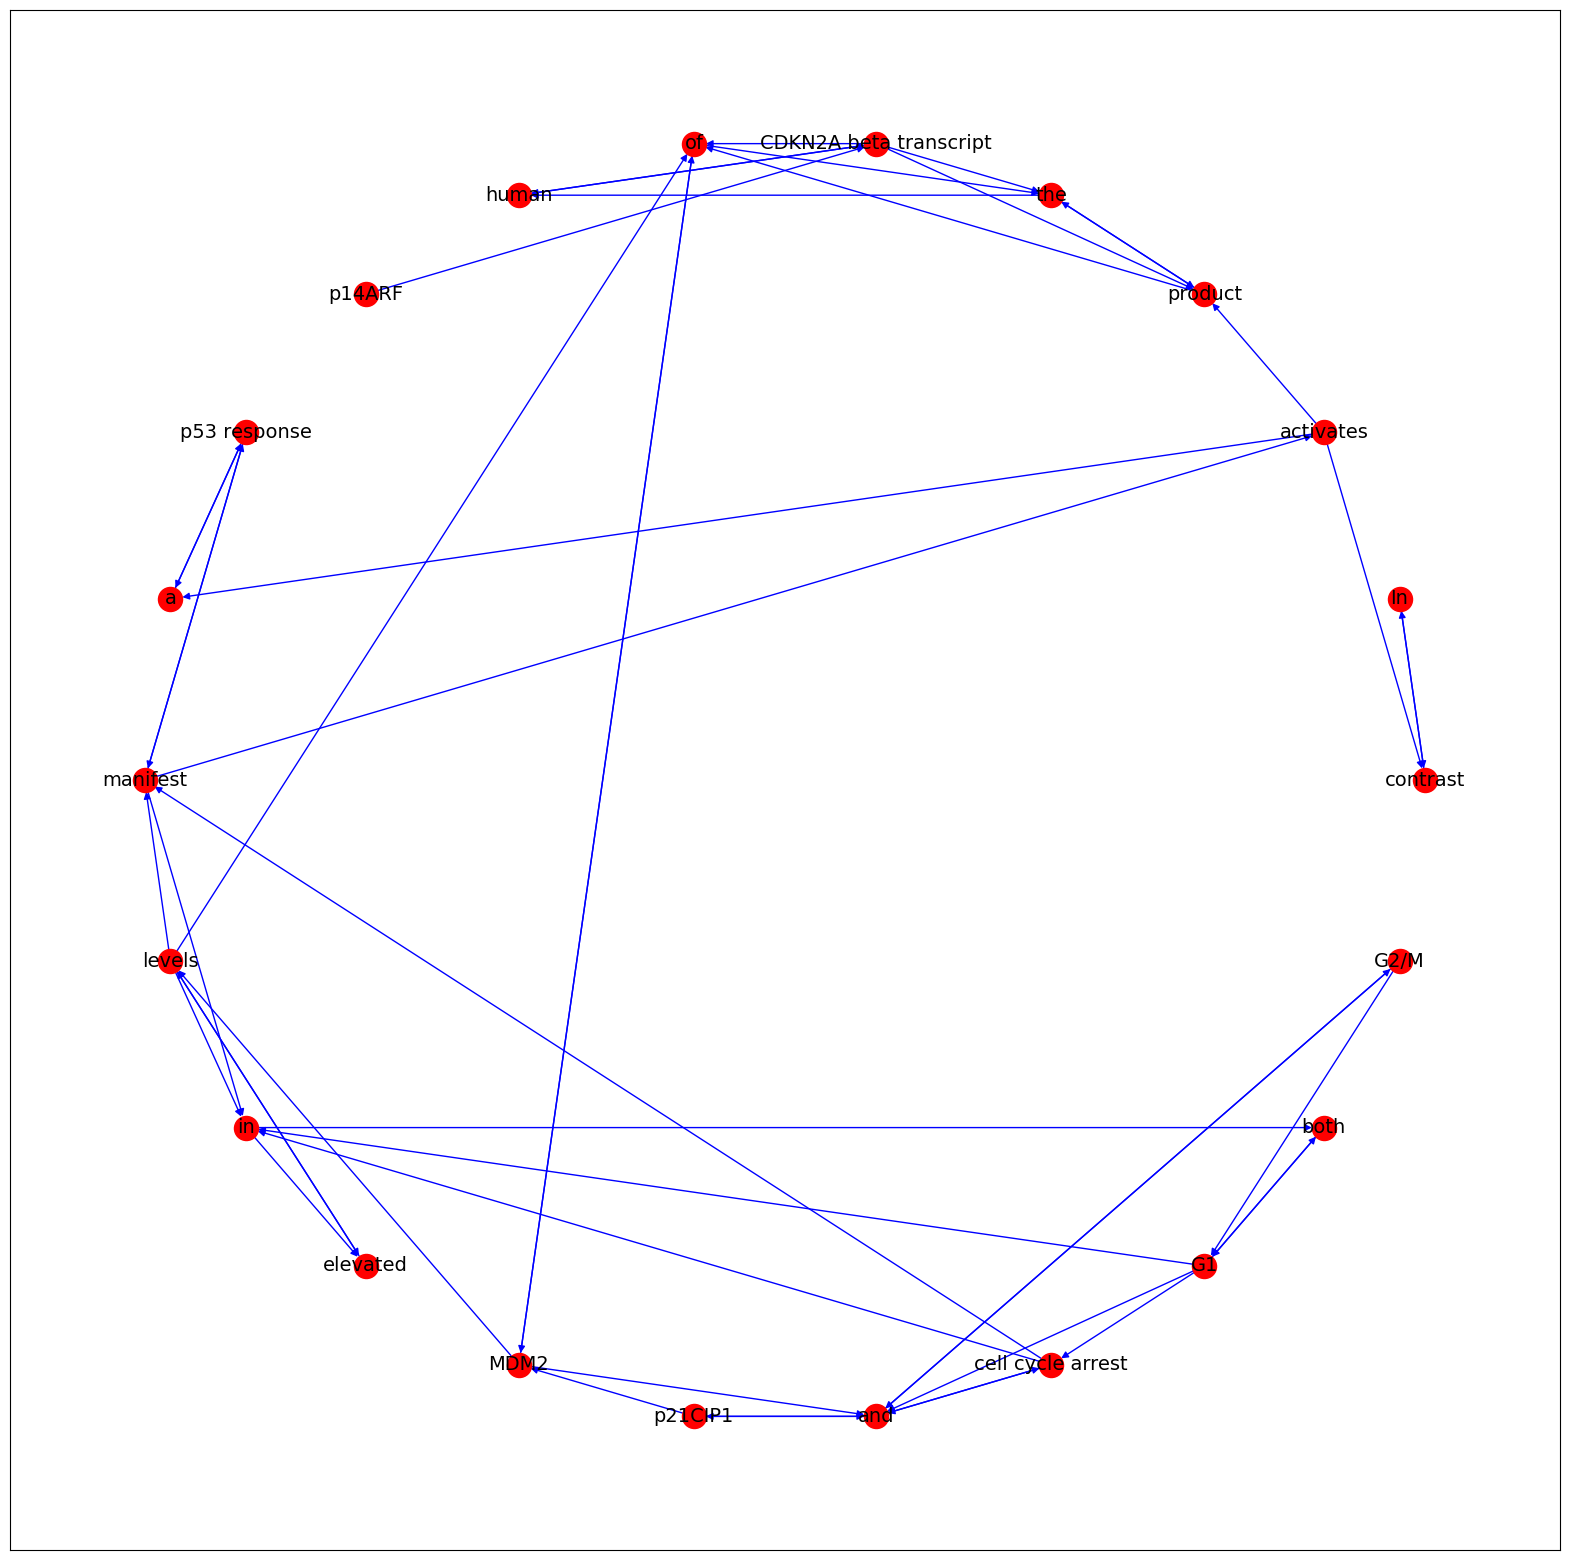

In [10]:
plot_circular_network(g)

In [11]:
s = startNode(g)
e = terminalNode(g)

In [28]:
%%time
ps = generateSimpleWeightedPaths(g)

CPU times: user 1min 6s, sys: 189 ms, total: 1min 6s
Wall time: 1min 6s


In [13]:
len(ps)

96800

#### The Conditional Dependence between CDKN2A Beta Transcript and p14ARF 
#### (They are supposed to be equivalent)

In [14]:
BayesProb(target=['p14ARF'], conditional=['CDKN2A beta transcript'], ps=ps)

['p14ARF', 'CDKN2A beta transcript'] ['CDKN2A beta transcript']
Numerator: 4400; Denominator: 38977
Pr(['p14ARF']|['CDKN2A beta transcript']): 0.112887


0.11288708725658722

In [15]:
BayesProb(target=['CDKN2A beta transcript'], conditional=['p14ARF'], ps=ps)

['CDKN2A beta transcript', 'p14ARF'] ['p14ARF']
Numerator: 4400; Denominator: 4400
Pr(['CDKN2A beta transcript']|['p14ARF']): 1.000000


1.0

#### The Conditional Dependence between CDKN2A Beta Transcript and MDM2 
#### (CDKN2A is supposed to activate p53 and then p53 activates MDM2 expression) 

In [16]:
BayesProb(target=['MDM2'], conditional=['CDKN2A beta transcript'], ps=ps)

['MDM2', 'CDKN2A beta transcript'] ['CDKN2A beta transcript']
Numerator: 33710; Denominator: 38977
Pr(['MDM2']|['CDKN2A beta transcript']): 0.864869


0.8648690253226262

In [17]:
BayesProb(target=['MDM2'], conditional=['activates','CDKN2A beta transcript'], ps=ps)

['MDM2', 'activates', 'CDKN2A beta transcript'] ['activates', 'CDKN2A beta transcript']
Numerator: 12407; Denominator: 13243
Pr(['MDM2']|['activates', 'CDKN2A beta transcript']): 0.936872


0.9368723098995696

In [18]:
BayesProb(target=['MDM2'], conditional=['p53 response','activates','CDKN2A beta transcript'], ps=ps)

['MDM2', 'p53 response', 'activates', 'CDKN2A beta transcript'] ['p53 response', 'activates', 'CDKN2A beta transcript']
Numerator: 7102; Denominator: 7680
Pr(['MDM2']|['p53 response', 'activates', 'CDKN2A beta transcript']): 0.924740


0.9247395833333333

In [19]:
BayesProb(target=['MDM2'], conditional=['p53 response', 'CDKN2A beta transcript'], ps=ps)

['MDM2', 'p53 response', 'CDKN2A beta transcript'] ['p53 response', 'CDKN2A beta transcript']
Numerator: 10554; Denominator: 11335
Pr(['MDM2']|['p53 response', 'CDKN2A beta transcript']): 0.931098


0.9310983678870755

#### The Conditional Dependence between p53 and MDM2 
#### (p53 is sipposed to activate MDM2 expression) 

In [20]:
BayesProb(target=['MDM2'], conditional=['p53 response', 'activates'], ps=ps)

['MDM2', 'p53 response', 'activates'] ['p53 response', 'activates']
Numerator: 12632; Denominator: 21415
Pr(['MDM2']|['p53 response', 'activates']): 0.589867


0.5898669157132851

#### The Conditional Depdendence between CDKN2A Beta Transcript and p53
#### (CDKN2A Beta transcript is supposed to activate p53 via its gene product p14ARF)

In [21]:
BayesProb(target=['p53 response'], conditional=['activates','CDKN2A beta transcript'], ps=ps)

['p53 response', 'activates', 'CDKN2A beta transcript'] ['activates', 'CDKN2A beta transcript']
Numerator: 7680; Denominator: 13243
Pr(['p53 response']|['activates', 'CDKN2A beta transcript']): 0.579929


0.5799290191044325

In [22]:
BayesProb(target=['p53 response'], conditional=['activates'], ps=ps)

['p53 response', 'activates'] ['activates']
Numerator: 21415; Denominator: 35063
Pr(['p53 response']|['activates']): 0.610758


0.6107577788552034

In [23]:
BayesProb(target=['p53 response'], conditional=['activates', 'p14ARF'], ps=ps)

['p53 response', 'activates', 'p14ARF'] ['activates', 'p14ARF']
Numerator: 460; Denominator: 892
Pr(['p53 response']|['activates', 'p14ARF']): 0.515695


0.515695067264574

In [24]:
BayesProb(target=['p53 response'], conditional=['activates', 'p14ARF', 'CDKN2A beta transcript'], ps=ps)
# Expected as p14ARF has a conditional probability of 1 to CDKN2A beta transcript

['p53 response', 'activates', 'p14ARF', 'CDKN2A beta transcript'] ['activates', 'p14ARF', 'CDKN2A beta transcript']
Numerator: 460; Denominator: 892
Pr(['p53 response']|['activates', 'p14ARF', 'CDKN2A beta transcript']): 0.515695


0.515695067264574

#### The Conditional Dependence between p53 and MDM2

#### (The MDM2 and CDKN2A beta transcript are supposed to activate p53)

In [29]:
BayesProb(target=['p53 response'], conditional=['activates', 'MDM2', 'CDKN2A beta transcript'], ps=ps)

['p53 response', 'activates', 'MDM2', 'CDKN2A beta transcript'] ['activates', 'MDM2', 'CDKN2A beta transcript']
Numerator: 7078; Denominator: 12267
Pr(['p53 response']|['activates', 'MDM2', 'CDKN2A beta transcript']): 0.576995


0.5769951903480883

### Generate a graph that follows the dependency parsing

In [25]:
h = createTokenDiGraphwithContraction(doc)

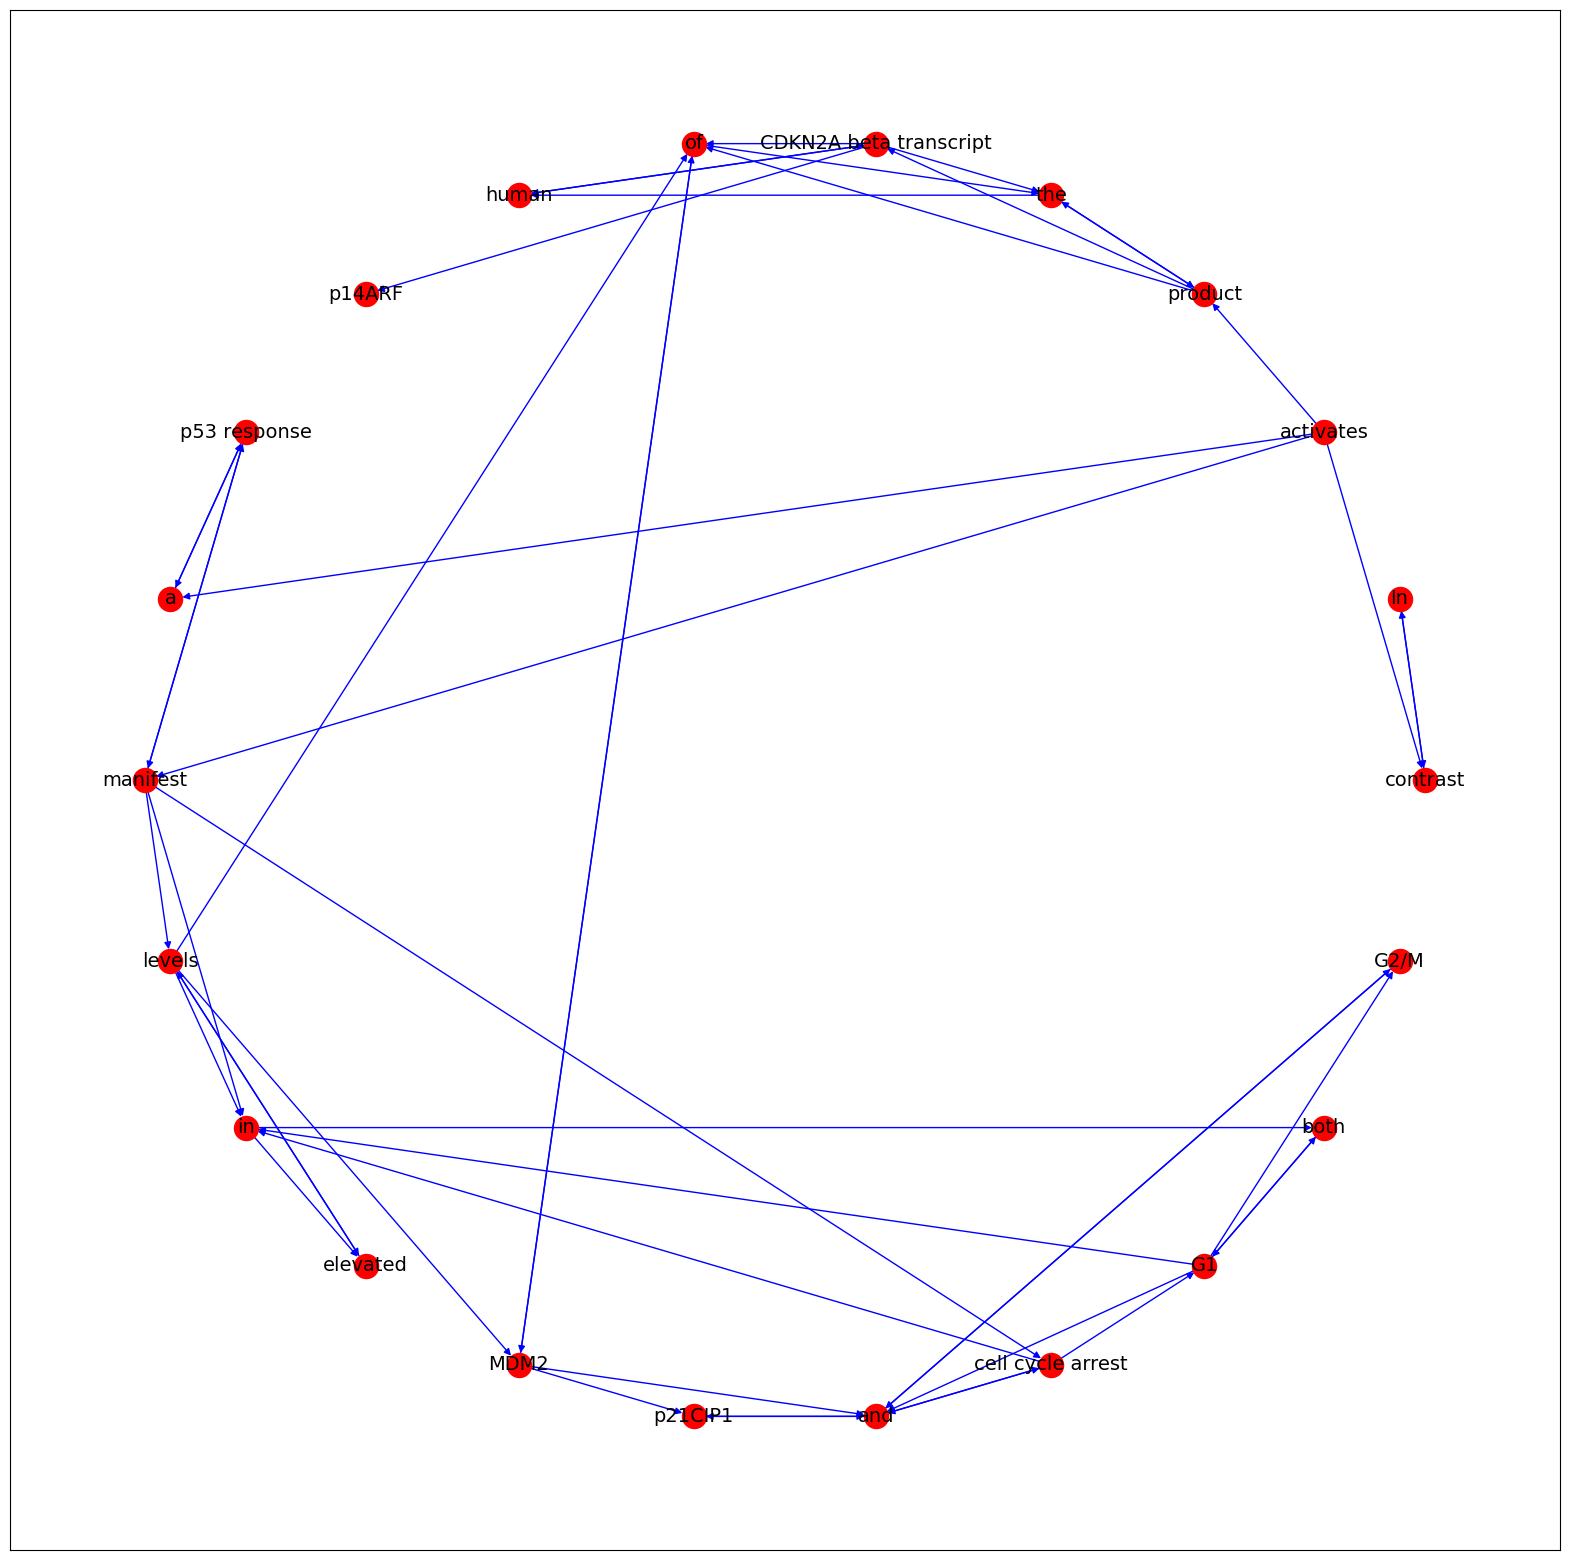

In [26]:
plot_circular_network(h)

In [61]:
%%time
ps = generateSimpleWeightedPaths(h)
len(ps)

CPU times: user 1min 11s, sys: 147 ms, total: 1min 11s
Wall time: 1min 11s


96800

In [63]:
BayesProb(target=['p14ARF'], conditional=['CDKN2A beta transcript'], ps=ps)
BayesProb(target=['CDKN2A beta transcript'], conditional=['p14ARF'], ps=ps)

['p14ARF', 'CDKN2A beta transcript'] ['CDKN2A beta transcript']
Numerator: 17788; Denominator: 30987
Pr(['p14ARF']|['CDKN2A beta transcript']): 0.574047
['CDKN2A beta transcript', 'p14ARF'] ['p14ARF']
Numerator: 17788; Denominator: 22188
Pr(['CDKN2A beta transcript']|['p14ARF']): 0.801695


0.8016946096989364

In [66]:
BayesProb(target=['MDM2'], conditional=['CDKN2A beta transcript'], ps=ps)
BayesProb(target=['MDM2'], conditional=['activates','CDKN2A beta transcript'], ps=ps)
BayesProb(target=['MDM2'], conditional=['p53 response', 'activates'], ps=ps)
BayesProb(target=['MDM2'], conditional=['p53 response', 'CDKN2A beta transcript'], ps=ps)
BayesProb(target=['MDM2'], conditional=['p53 response','activates','CDKN2A beta transcript'], ps=ps)

['MDM2', 'CDKN2A beta transcript'] ['CDKN2A beta transcript']
Numerator: 15423; Denominator: 30987
Pr(['MDM2']|['CDKN2A beta transcript']): 0.497725
['MDM2', 'activates', 'CDKN2A beta transcript'] ['activates', 'CDKN2A beta transcript']
Numerator: 579; Denominator: 1231
Pr(['MDM2']|['activates', 'CDKN2A beta transcript']): 0.470349
['MDM2', 'p53 response', 'activates'] ['p53 response', 'activates']
Numerator: 552; Denominator: 1329
Pr(['MDM2']|['p53 response', 'activates']): 0.415350
['MDM2', 'p53 response', 'CDKN2A beta transcript'] ['p53 response', 'CDKN2A beta transcript']
Numerator: 1300; Denominator: 1971
Pr(['MDM2']|['p53 response', 'CDKN2A beta transcript']): 0.659564
['MDM2', 'p53 response', 'activates', 'CDKN2A beta transcript'] ['p53 response', 'activates', 'CDKN2A beta transcript']
Numerator: 125; Denominator: 200
Pr(['MDM2']|['p53 response', 'activates', 'CDKN2A beta transcript']): 0.625000


0.625

In [68]:
BayesProb(target=['p53 response'], conditional=['p14ARF'], ps=ps)
BayesProb(target=['p53 response'], conditional=['activates', 'p14ARF'], ps=ps)
BayesProb(target=['p53 response'], conditional=['activates', 'CDKN2A beta transcript'], ps=ps)
BayesProb(target=['p53 response'], conditional=['activates', 'p14ARF', 'CDKN2A beta transcript'], ps=ps)

['p53 response', 'p14ARF'] ['p14ARF']
Numerator: 1039; Denominator: 22188
Pr(['p53 response']|['p14ARF']): 0.046827
['p53 response', 'activates', 'p14ARF'] ['activates', 'p14ARF']
Numerator: 107; Denominator: 715
Pr(['p53 response']|['activates', 'p14ARF']): 0.149650
['p53 response', 'activates', 'CDKN2A beta transcript'] ['activates', 'CDKN2A beta transcript']
Numerator: 200; Denominator: 1231
Pr(['p53 response']|['activates', 'CDKN2A beta transcript']): 0.162470
['p53 response', 'activates', 'p14ARF', 'CDKN2A beta transcript'] ['activates', 'p14ARF', 'CDKN2A beta transcript']
Numerator: 107; Denominator: 715
Pr(['p53 response']|['activates', 'p14ARF', 'CDKN2A beta transcript']): 0.149650


0.14965034965034965

In [69]:
BayesProb(target=['p53 response'], conditional=['MDM2'], ps=ps)
BayesProb(target=['p53 response'], conditional=['activates', 'MDM2'], ps=ps)
BayesProb(target=['p53 response'], conditional=['activates', 'MDM2', 'CDKN2A beta transcript'], ps=ps)
BayesProb(target=['p53 response'], conditional=['activates', 'MDM2', 'p14ARF'], ps=ps)

['p53 response', 'MDM2'] ['MDM2']
Numerator: 5044; Denominator: 40477
Pr(['p53 response']|['MDM2']): 0.124614
['p53 response', 'activates', 'MDM2'] ['activates', 'MDM2']
Numerator: 552; Denominator: 1480
Pr(['p53 response']|['activates', 'MDM2']): 0.372973
['p53 response', 'activates', 'MDM2', 'CDKN2A beta transcript'] ['activates', 'MDM2', 'CDKN2A beta transcript']
Numerator: 125; Denominator: 579
Pr(['p53 response']|['activates', 'MDM2', 'CDKN2A beta transcript']): 0.215889
['p53 response', 'activates', 'MDM2', 'p14ARF'] ['activates', 'MDM2', 'p14ARF']
Numerator: 52; Denominator: 171
Pr(['p53 response']|['activates', 'MDM2', 'p14ARF']): 0.304094


0.30409356725146197

The difference between the probability of any combination of tokens can be used to estimate the average treatment effect (ATE) as suggested by Pearl.